In [1]:
import numpy as np
import math
import open3d as o3d
import cv2
import matplotlib.pyplot as plt
import copy

In [2]:
pcd = o3d.io.read_point_cloud("pcd2.pcd")
o3d.visualization.draw([pcd])

In [5]:
from PIL import Image
from skimage import io,measure
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import numpy as np

<Figure size 640x480 with 0 Axes>

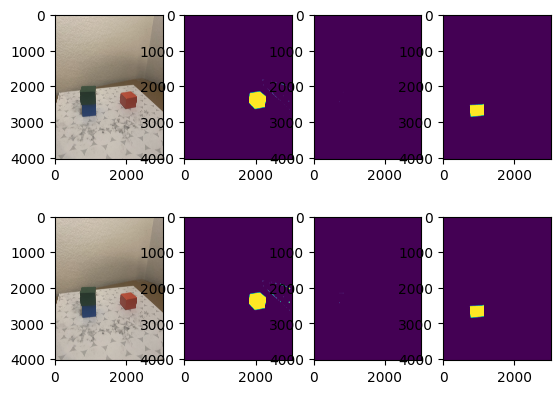

In [53]:
class Block():
    def __init__(self,name,pcd):
        self.blockPCD = pcd
        self.name = name
        # Removes outlier points by fitting block into largest cluster
        self.clusterBlockPCD()
        self.blockAABB = self.blockPCD.get_axis_aligned_bounding_box()
        self.robotCoordsDuringImage = np.array([-0.67743,-0.13328,-0.008594]) # the coordinates of the gripper when it took the images
        self.camCoords = self.getCameraCoordinates()
        self.robotCoords = self.getRobotCoordinates()
        self.currentCamCoords = self.camCoords
        
    def clusterBlockPCD(self):
        # modifies block PCD to only contain points in the largest cluster found with DBScan
        # eps found experimentally
        with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Error) as cm:
                # eps is radius
                # rejects points that are too small
                labels = np.array(self.blockPCD.cluster_dbscan(eps=0.013, min_points=20, print_progress=False))

        max_label = labels.max()
        colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        colors[labels < 0] = 0
        clusters = {}
        for i in range(0,max_label + 1):
            clusters[i] = []

        for i in range(0,len(labels)):
            if labels[i] != -1:
                clusters[labels[i]].append(i)

        clusterPCDs = []
        for clusterLabel in clusters:
            clusterPCD = self.blockPCD.select_by_index(clusters[clusterLabel])
            clusterPCDs.append(clusterPCD)
        self.blockPCD = clusterPCDs[0]
    
    def getCameraCoordinates(self):
        # returns the (x,y,z) coordinates in the camera's coordinates frame of where the gripper should be placed
        # center of front-facing axis-aligned bounding box
        x,y = self.blockAABB.get_center()[0:2]
        z = self.blockAABB.get_min_bound()[2]
        return (x,y,z)
    
    def getRobotCoordinates(self):
        xGripper,yGripper,zGripper = self.robotCoordsDuringImage
        xCam,yCam,zCam = self.camCoords
        #xGripper_Goal = xGripper - zCam
        #yGripper_Goal = yGripper + xCam
        #zGripper_Goal = zGripper - yCam
        # changed to deltas
        deltaXGripper = -zCam
        deltaYGripper = xCam
        deltaZGripper = -yCam
        return np.array([deltaXGripper,deltaYGripper,deltaZGripper])
    
    def move(self,goalCamCoords):
        self.currentCamCoords = goalCamCoords


1


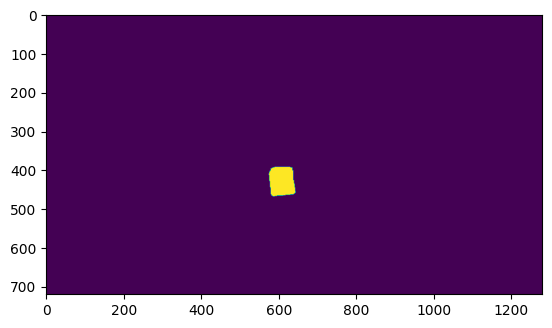

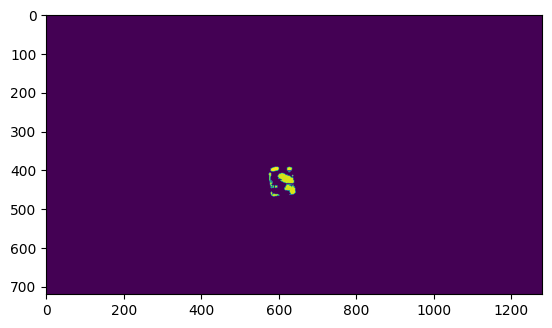

In [52]:
def getMask(img,minHSV,maxHSV):
    # :img 3-channel rgb image as numpy array
    # :hsvBounds tuple containing 2 triplets with hsv bounds. ex: (0,110,20),(15,255,255)
    # Segments image based on bounds in hsv color space (1st converts image from rgb space to hsv)
    # returns a 1-channel numpy array that results from segmentation
    # convert image to hsv
    hsv = cv.cvtColor(img,cv.COLOR_RGB2HSV)
    mask = cv.inRange(img,hsvBounds[0],hsvBounds[1])
    plt.imshow(mask)
    # binary closing with 10 x 10 kernel (dilation then erosion) to fill in gaps
    closedMask = nd.binary_closing(mask,np.ones((10,10)),iterations=5).astype(int)
    return closedMask

def getBlocks(colorImage,depthImage):
    # mask the depth image using the monochromatic segmented image so that only blocks have defined values
    
    redMask = getMask(colorImage,(0,110,20),(15,255,255))
    yellowMask = getMask(colorImage,(20,90,20),(35,255,255))
    blueMask = getMask(colorImage,(95,90,20),(130,255,255)) 
   
    redDepthImage = np.multiply(depthImage,closedRedMask)
    yellowDepthImage = np.multiply(depthImage,closedYellowMask)
    blueDepthImage = np.multiply(depthImage,closedBlueMask)

    extrinsics = np.array([[-0.99468624,-0.09739136,-0.03337981,-0.01548516]
                  [0.02688587,0.06724571,-0.99737413,-0.28035581]
                  [0.09938027,-0.99297177,-0.06426993,0.17600367]
                  [0,0,0,1]])

    depth_scale = 10**-5
    
    # SEGMENT PCD INTO RED,YELLOW,BLUE BLOCKS    
    redRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(redDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1/depth_scale)

    yellowRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(yellowDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1/depth_scale)
    
    blueRGBD_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(blueDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1/depth_scale)
    
    redPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        redRGDB_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    yellowPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        yellowRGDB_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    bluePCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        blueRGBD_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    
    # flip point clouds since they start upside down
    # redPCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    # greenPCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    # bluePCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    redPCD.paint_uniform_color([1,0,0])
    yellowPCD.paint_uniform_color([0,1,0])
    bluePCD.paint_uniform_color([0,0,1])
    redBlock = Block("redBlock",redPCD)
    greenBlock = Block("greenBlock",greenPCD)
    blueBlock = Block("blueBlock",bluePCD)
    showImages(images)
    o3d.visualization.draw([redPCD,ye])
    '''
    # return (redBlock,greenBlock,blueBlock)
    
colorImage = np.load("colorImage2.npy")
depthImage = np.load("depthImage2.npy")
getBlocksFromImages(colorImage,depthImage)

<Figure size 640x480 with 0 Axes>

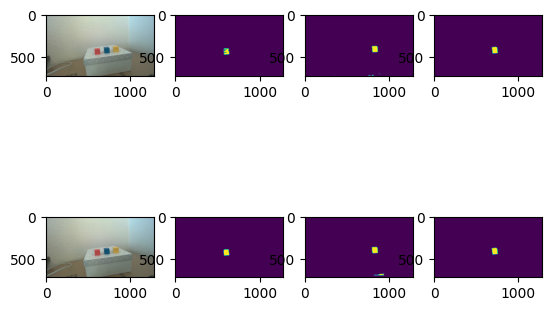

<Figure size 640x480 with 0 Axes>

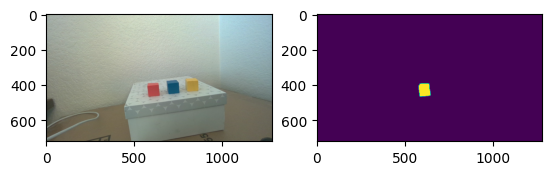

In [27]:
fig = plt.figure()
f,axarr = plt.subplots(2,4)
img = np.load("colorImage2.npy")
# img = io.imread("colorImage1.npy")
# convert image to hsv
hsv = cv.cvtColor(img,cv.COLOR_RGB2HSV)
# HSV visual - https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv
redMask = cv.inRange(hsv,(0,110,20),(15,255,255))
yellowMask = cv.inRange(hsv,(20,90,20),(35,255,255))
blueMask = cv.inRange(hsv,(95,90,20),(130,255,255)) 
# binary closing with 10 x 10 kernel (dilation then erosion) to fill in gaps
closedRedMask = nd.binary_closing(redMask,np.ones((10,10)),iterations=5)
closedYellowMask = nd.binary_closing(yellowMask,np.ones((10,10)),iterations=5)
closedBlueMask = nd.binary_closing(blueMask,np.ones((10,10)),iterations=5)
axarr[0][0].imshow(img)
axarr[0][1].imshow(redMask)
axarr[0][2].imshow(yellowMask)
axarr[0][3].imshow(blueMask)
axarr[1][0].imshow(img)
axarr[1][1].imshow(closedRedMask)
axarr[1][2].imshow(closedYellowMask)
axarr[1][3].imshow(closedBlueMask)

fig2 = plt.figure()
f2,axarr2 = plt.subplots(1,2)
axarr2[0].imshow(img)
axarr2[1].imshow(closedRedMask)

In [ ]:
fig = plt.figure()
f,axarr = plt.subplots(2,4)
mask1,mask2 = None,None
for i in range(1866,1867):
    path = f"IMG_{i}.jpeg"
    img = io.imread(path)
    # convert image to hsv
    hsv = cv.cvtColor(img,cv.COLOR_RGB2HSV)
    # HSV visual - https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv
    redMask = cv.inRange(hsv,(0,110,20),(15,255,255))
    greenMask = cv.inRange(hsv,(35,90,10),(85,255,255))
    blueMask = cv.inRange(hsv,(95,90,20),(130,255,255)) 
    # binary closing with 10 x 10 kernel (dilation then erosion) to fill in gaps
    closedRedMask = nd.binary_closing(redMask,np.ones((10,10)),iterations=5)
    closedGreenMask = nd.binary_closing(greenMask,np.ones((10,10)),iterations=5)
    closedBlueMask = nd.binary_closing(blueMask,np.ones((10,10)),iterations=5)
    mask1,mask2 = closedGreenMask,closedBlueMask
    axarr[0][0].imshow(img)
    axarr[0][1].imshow(redMask)
    axarr[0][2].imshow(greenMask)
    axarr[0][3].imshow(blueMask)
    axarr[1][0].imshow(img)
    axarr[1][1].imshow(closedRedMask)
    axarr[1][2].imshow(closedGreenMask)
    axarr[1][3].imshow(closedBlueMask)
